Kaggle Link:
https://www.kaggle.com/competitions/tabular-playground-series-sep-2022
<br>


In [ ]:
# import initial libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import time series libraries
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller, acf, pacf

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload() # Select your kaggle.json file when prompted

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c tabular-playground-series-sep-2022

  0% 0.00/615k [00:00<?, ?B/s]
100% 615k/615k [00:00<00:00, 664MB/s]


In [ ]:
!unzip tabular-playground-series-sep-2022.zip

Archive:  tabular-playground-series-sep-2022.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
# import the raw data from kaggle
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

#display the shape of the training set
df.shape

(70128, 6)

In [ ]:
test.head()

,row_id,date,country,store,product
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques


In [ ]:
test.shape

(17520, 5)

In [ ]:
df.head()

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


<h3>Data Understanding</h3>

* [country] variable: has 6 unique values {'Belgium', 'France', 'Germany', 'Italy', 'Poland', 'Spain'}<br>
* Each country has two stores {'KaggleMart', 'KaggleRama'}<br>
* [product] variable: has 4 unique values {'Kaggle Advanced Techniques', 'Kaggle Getting Started', 'Kaggle Recipe Book', 'Kaggle for Kids: One Smart Goose'}<br>
* df[date] variable: has 4 consecutive years {2017, 2018, 2019, 2020}, each year has 12 months with values roughly ranged between {1344 and 1488}.<br>

<b>Initial points from Pandas calculations</b><br>
* [num_sold] is <i>Right-skewed</i>.<br>

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   row_id    70128 non-null  int64 
 1   date      70128 non-null  object
 2   country   70128 non-null  object
 3   store     70128 non-null  object
 4   product   70128 non-null  object
 5   num_sold  70128 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 3.2+ MB


In [ ]:
# change the dtype of the columns

df['date'] = pd.to_datetime(df['date'])

for i in df.columns:
  if df[i].dtype == 'object':
    df[i] = df[i].astype('category')

In [ ]:
# fathom data distribution
round(df.describe(),2)

,row_id,date,num_sold
count,70128.00,70128,70128.00
mean,35063.50,2018-12-31 23:59:59.999999744,194.30
min,0.00,2017-01-01 00:00:00,19.00
25%,17531.75,2018-01-01 00:00:00,95.00
50%,35063.50,2019-01-01 00:00:00,148.00
75%,52595.25,2020-01-01 00:00:00,283.00
max,70127.00,2020-12-31 00:00:00,986.00
std,20244.35,NaN,126.89


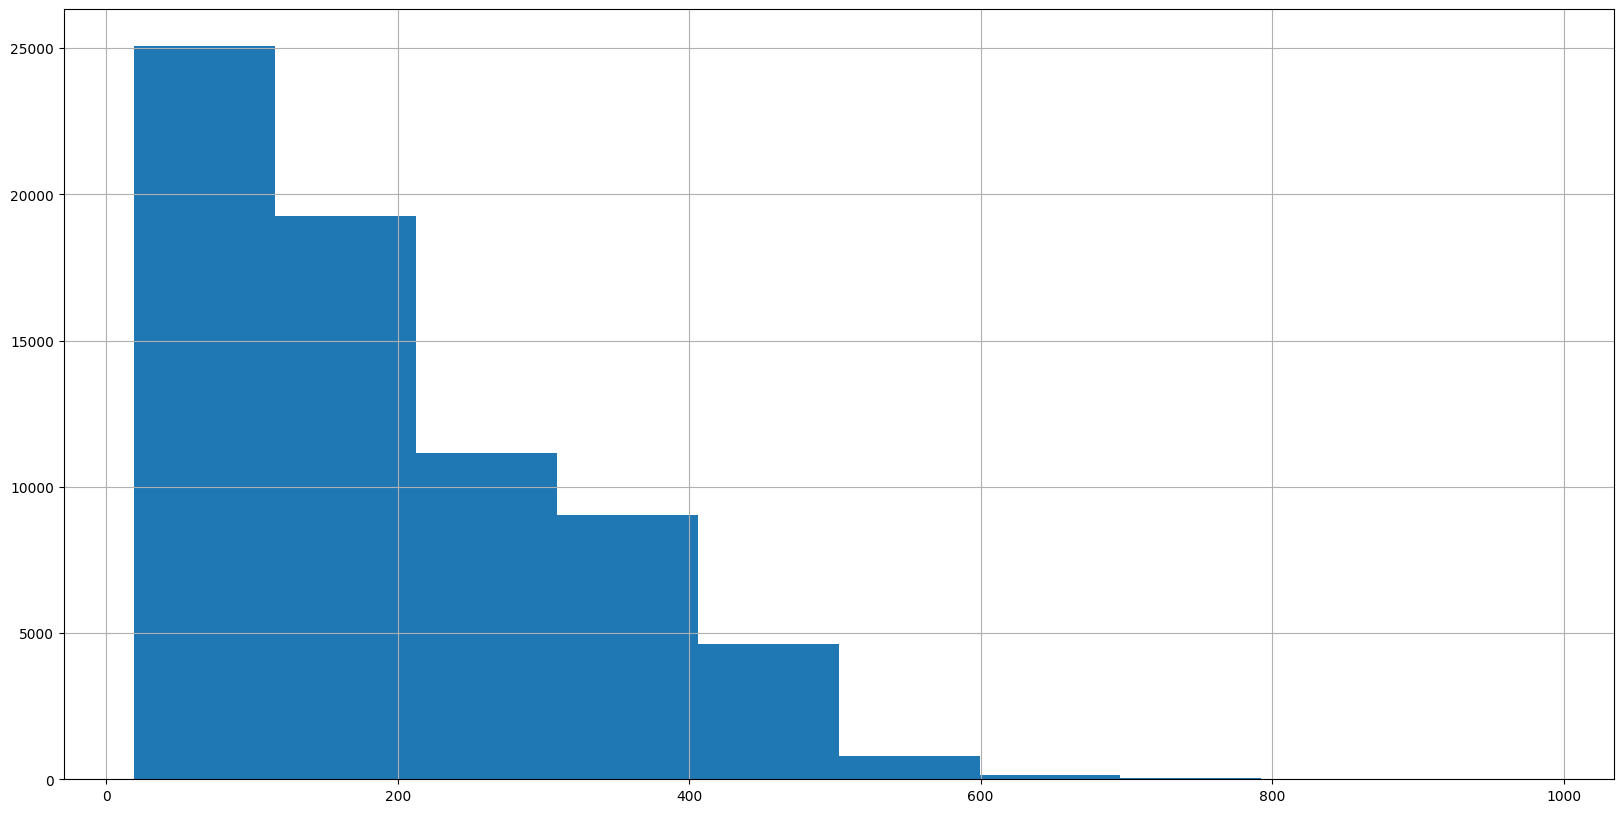

In [ ]:
# check if it's left-skewed or right-skewed
plt.figure(figsize=(20,10))
df['num_sold'].hist();

In [ ]:
# create a new 2 columns {year, month}
df['year'] = pd.to_datetime(df['date']).dt.year
df['month'] = pd.to_datetime(df['date']).dt.month

# just to better fayjom the time series range
df.groupby('year')['month'].value_counts().sort_index(ascending=True)

year  month
2017  1        1488
      2        1344
      3        1488
      4        1440
      5        1488
      6        1440
      7        1488
      8        1488
      9        1440
      10       1488
      11       1440
      12       1488
2018  1        1488
      2        1344
      3        1488
      4        1440
      5        1488
      6        1440
      7        1488
      8        1488
      9        1440
      10       1488
      11       1440
      12       1488
2019  1        1488
      2        1344
      3        1488
      4        1440
      5        1488
      6        1440
      7        1488
      8        1488
      9        1440
      10       1488
      11       1440
      12       1488
2020  1        1488
      2        1392
      3        1488
      4        1440
      5        1488
      6        1440
      7        1488
      8        1488
      9        1440
      10       1488
      11       1440
      12       1488
Name: count, dtype: int64

In [ ]:
# esnure we don't have any missing values
df.isna().sum().sum()

np.int64(0)

<h3>Some Data Visualization</h3>

/tmp/ipython-input-689327292.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('product')['num_sold'].sum().sort_values(ascending=True).plot.bar()


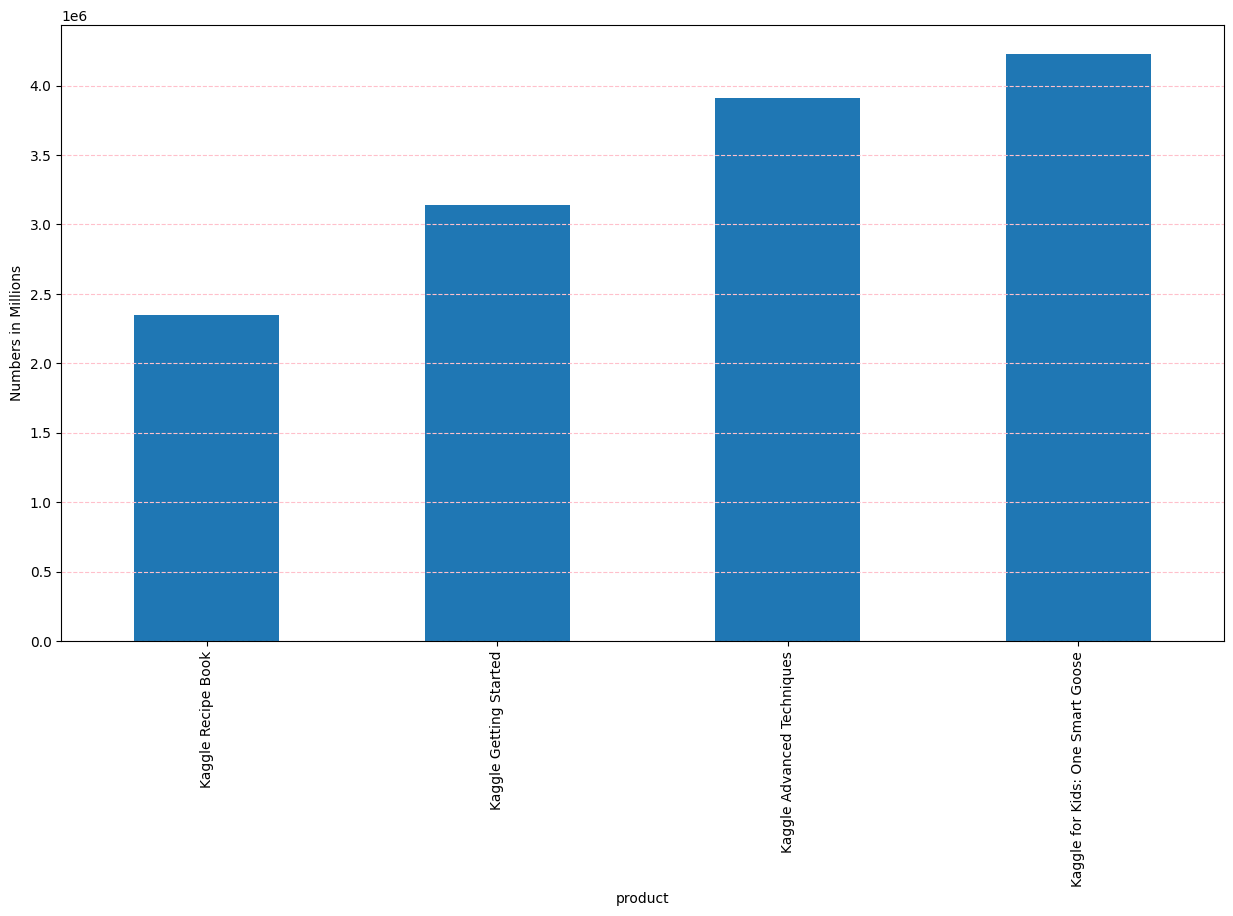

In [ ]:
# which products we focus on, drive $$$
plt.figure(figsize=(15,8))
df.groupby('product')['num_sold'].sum().sort_values(ascending=True).plot.bar()
plt.ylabel("Numbers in Millions")
plt.grid(axis='y', linestyle='--',color='pink')
plt.show();

<b>The next line plot has a lot of noise!</b>
<br>
<i>I need to identify the time series decomposition:</i><br>
a. Trend<br>
b. Season<br>
c. Stationary<br>
d. Residuals<br>

So I need to stretch this line a bit :)

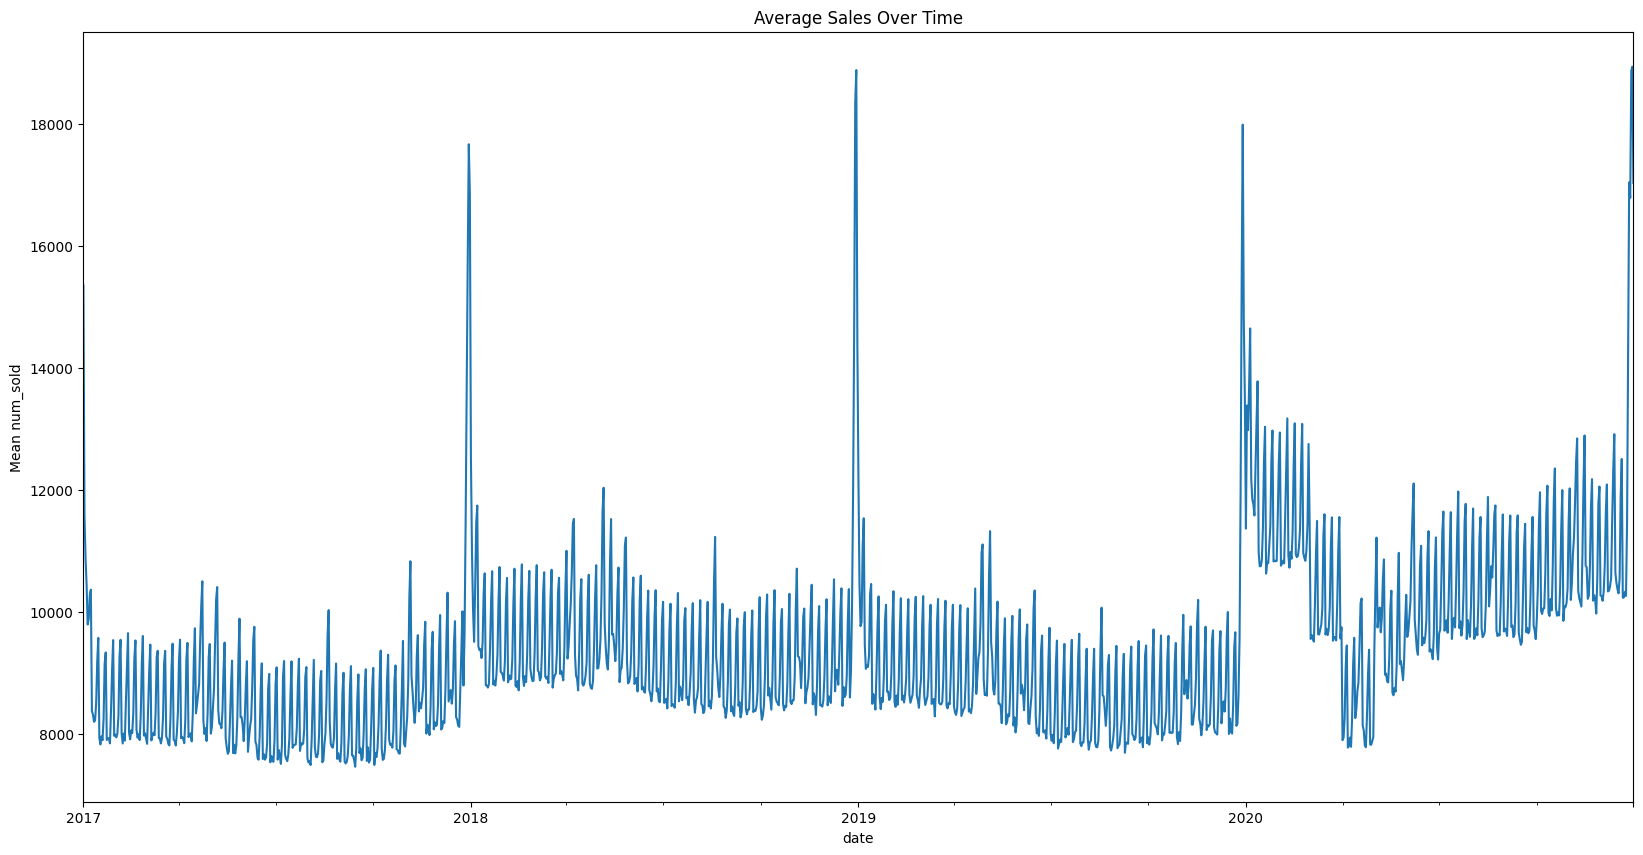

In [ ]:
# I want to observe how the sales fluctuate through the years
plt.figure(figsize=(20,10))
df.groupby("date")["num_sold"].sum().plot()
plt.title("Average Sales Over Time")
plt.ylabel("Mean num_sold")
plt.show()

<b>Resample the weekly sales look much neat!</b>
The second line plot is nice, it reflects trend effect and residuals but the seasonality is still not clear!

<Axes: xlabel='date'>

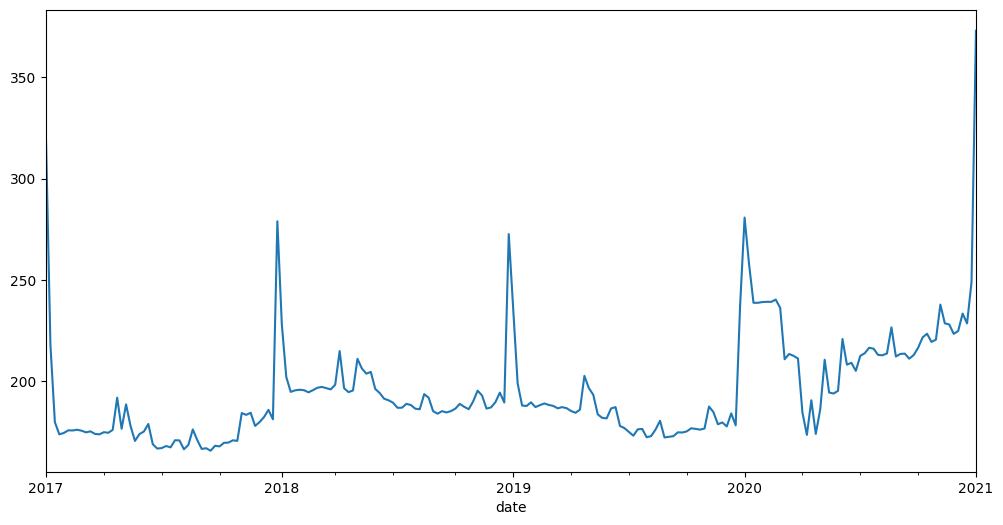

In [ ]:
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)

# Resample to weekly mean
df_resampled = df["num_sold"].resample("W").mean()

df_resampled.plot(figsize=(12,6))

Now, we can see the trend, the uprising effect, seasonality and residuals.
<b>We can identify the business opportunities!</b>

/tmp/ipython-input-3397070736.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df["num_sold"].resample("M").sum()


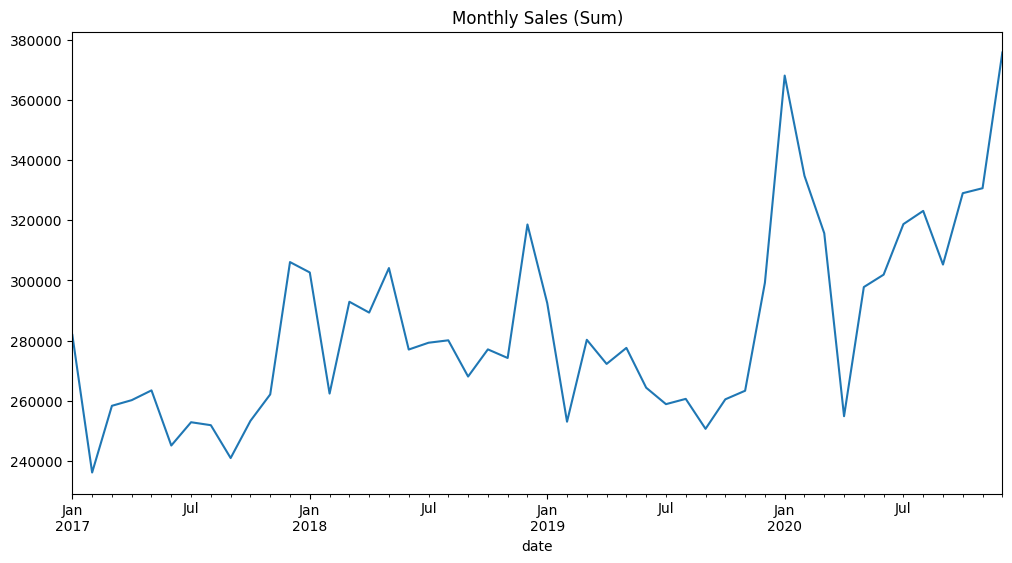

In [ ]:
# Resample the monthly total sales
monthly = df["num_sold"].resample("M").sum()
monthly.plot(figsize=(12,6), title="Monthly Sales (Sum)");

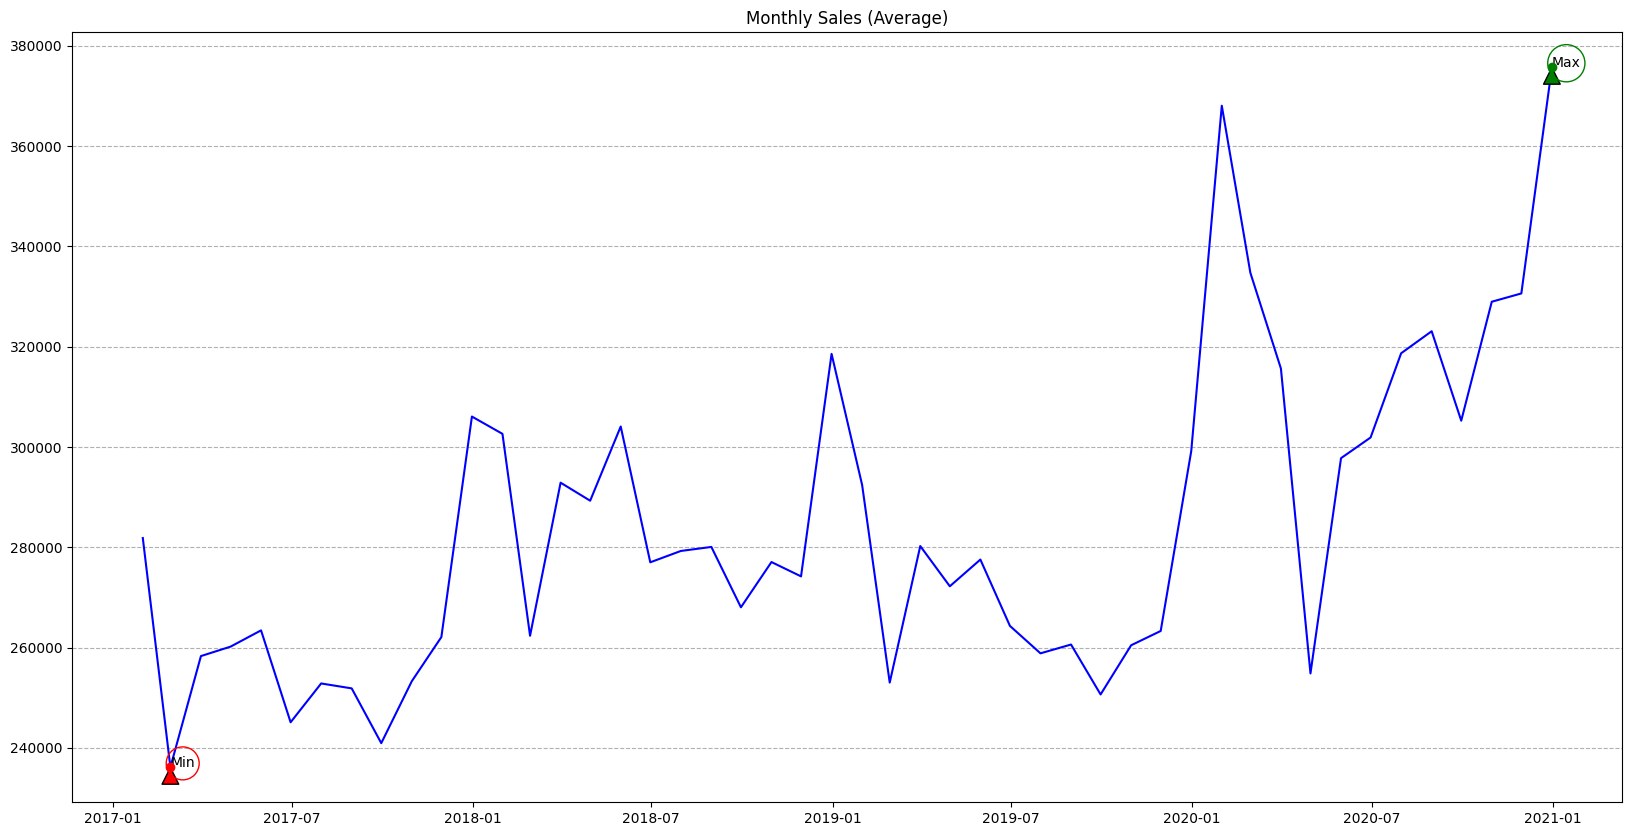

In [ ]:
# Find max and min
max_date = monthly.idxmax()
min_date = monthly.idxmin()
max_val = round(monthly.max())
min_val = round(monthly.min())

# Plot
plt.figure(figsize=(20,10))
plt.plot(monthly, label="Monthly Sales (Average)", color="blue")

# Add max marker
plt.scatter(max_date, max_val, color="green", zorder=7)
plt.annotate("Max", xy=(max_date, max_val), xytext=(max_date, max_val+10),
             arrowprops=dict(facecolor='green', shrink=0.08, width=2),
             bbox=dict(boxstyle="circle,pad=0.3", fc="none", ec="green"))

# Add min marker
plt.scatter(min_date, min_val, color="red", zorder=7)
plt.annotate("Min", xy=(min_date, min_val), xytext=(min_date, min_val-20),
             arrowprops=dict(facecolor='red', shrink=0.08, width=2),
             bbox=dict(boxstyle="circle,pad=0.3", fc="none", ec="red"))

plt.title("Monthly Sales (Average)")
plt.grid(axis='y',linestyle='--')
plt.show()

<b>The next code snippet is copied from this beauitful source:
[How to Decompose Time Series Data into Trend, Seasonal, and Residual Components in Python](https://www.statology.org/how-to-decompose-time-series-data-into-trend-seasonal-and-residual-components-in-python/)</b><br>
It was pretty challenge to get relevant python sources about time series forecasting and it took me many hours to grasp the concepts and implement these ideas in a clear way for me to fathom & explain in my video.<br><br>
<i>If you enjoy this code, feel free to check my YouTube video and subscribe for more of my content :)</i>

/tmp/ipython-input-2501627145.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df["num_sold"].resample("M").sum()


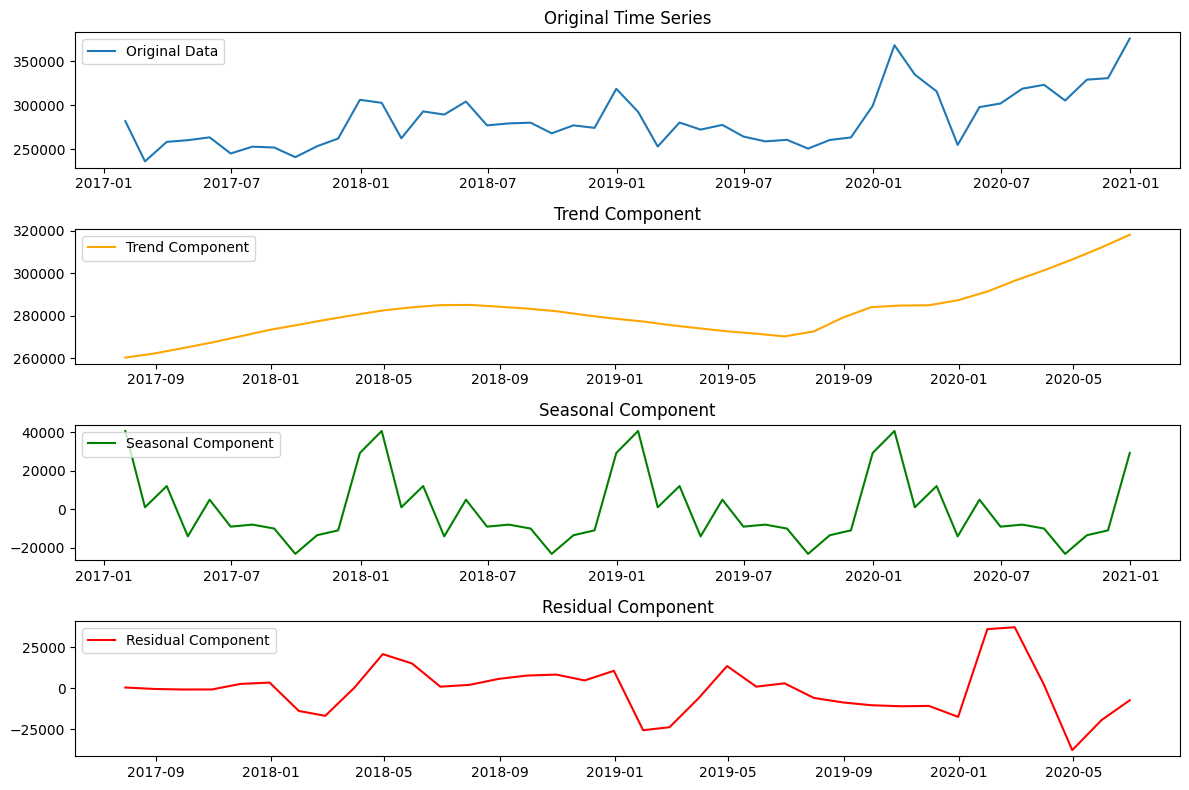

In [ ]:
# trend
from statsmodels.tsa.seasonal import seasonal_decompose

monthly = df["num_sold"].resample("M").sum()

# Decompose the time series data
decomposition = seasonal_decompose(monthly, model='additive')


# Plot the decomposed components
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(monthly, label='Original Data')
plt.title('Monthly Resample Total Sales')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend Decomposition', color='orange')
plt.title('Trend Decomposition')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonal Decomposition', color='green')
plt.title('Seasonal Decomposition')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residual Decomposition', color='red')
plt.title('Residual Decomposition')
plt.legend()

plt.tight_layout()
plt.show()